## Imports

In [71]:
import csv
import glob
import json
import itertools
import random
import requests
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import spacy
import textacy
import torch
from matplotlib.gridspec import GridSpec
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import framenet as fn
from spacy.symbols import nsubj, VERB
from tqdm import tqdm

from pytorch_pretrained_bert import BertForSequenceClassification, BertConfig, BertTokenizer
nlp = spacy.load("en_core_web_md")
%matplotlib inline
plt.style.use('seaborn')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Functions used

In [24]:
def convert_to_bert_tokens(sentence_1, sentence_2, max_len=60):
    """
    Converting two sentences to BERT tokens
    """
    tokens_1 = tokenizer.tokenize(sentence_1)
    tokens_2 = tokenizer.tokenize(sentence_2)
    
    # taken from the original repo
    while True:
        total_length = len(tokens_1) + len(tokens_2)
        if total_length <= max_len - 3:
            break
        if len(tokens_1) > len(tokens_2):
            tokens_1.pop()
        else:
            tokens_2.pop()
          
    if tokens_2:
        tokenized = ['[CLS]'] + tokens_1 + ['[SEP]'] + tokens_2 + ['[SEP]']
    else:
        tokenized = ['[CLS]'] + tokens_1 + ['[SEP]']

    to_pad = ['[PAD]']*(max_len - len(tokenized))
    return tokenized + to_pad, tokens_1, tokens_2

In [25]:
def convert_to_bert_inputs(sentence_1, sentence_2, max_len):
    """
    Converting two sentences to BERT inputs
    """
    tokens_all, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    input_ids = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokens_all))
    input_mask = (input_ids != 0).long()
    
    length_1 = len(tokens_1)
    length_2 = len(tokens_2)
    segment_ids = torch.zeros(max_len).long()
    if length_2 > 0:
        segment_ids[length_1 + 2:length_1 + length_2 + 3] = 1
    return input_ids,  input_mask, segment_ids,

In [27]:
def restore_model(path=None, sts=False, mnli=False):
    """
    Model loading. STS and MNLI require different initialization due to a different number of classes.
    """
    if path is None:
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    else:
        model_path = path + '/pytorch_model.bin'
        config_path = path + '/config.json'
        # Reading config
        config = BertConfig.from_json_file(config_path)

        # Initializing the model
        if sts:
            num_labels = 1
        elif mnli:
            num_labels = 3
        else:
            num_labels = 2
        model = BertForSequenceClassification(config, num_labels=num_labels)

        # Loading weights
        model.load_state_dict(torch.load(model_path))

    model.eval()
    return model

In [29]:
def visualize_single(att_map, sentence_1, sentence_2, max_len, n_layer, n_head):
    """
    Attention map for a given layer and head
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else:
        crop_len = len(tokens_1) + 2
    
    plt.figure(figsize=(16, 12))
    plt.imshow(att_map[n_layer, n_head, :crop_len, :crop_len], cmap='Reds')
    plt.xticks(range(crop_len), bert_tokens, rotation=60, fontsize=12)
    plt.yticks(range(crop_len), bert_tokens, fontsize=12)

    plt.grid(False)


In [31]:
def visualize_all(attn, crop_len, n_layers=12, n_heads=12, title=""):
    """
    Full grid of attention maps [12x12]
    """
    fig, axes = plt.subplots(n_layers, n_heads, figsize=(15, 12), sharex=True, sharey=True)
    
    for i in range(n_layers):
        for j in range(n_heads):
            im = axes[i, j].imshow(attn[i, j, :crop_len, :crop_len], cmap='Oranges')
            axes[i, j].axis('off')
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)


In [32]:
def visualize_before_and_after(before, after, title='', cmap="Greens"):
    """
    Visualize the difference between base BERT and fine-tuned BERT
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    ax1, ax2 = axes[0], axes[1]

    vmax = max(np.max(before), np.max(after))

    im = ax1.imshow(before, cmap=cmap, vmax=vmax)
    ax1.set_title('Base model')
    ax1.grid(False)

    im = ax2.imshow(after, cmap=cmap, vmax=vmax)
    ax2.set_title('Fine-tuned model')
    ax2.grid(False)

    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)


In [33]:
# See spacy docs for tag-pos relation
def detect_all_pos(sentence, pos='PRON'):
    """
    Detect all tokens with a given POS tag
    """
    if pos not in ['PRON', 'VERB', 'NOUN']:
        raise ValueError("POS not recognized")
        
    pos2tag = {'PRON': ['PRP', 'PRP$'],
               'NOUN': ['NN', 'NNP', 'NNPS', 'NNS'],
               'VERB': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']}
    
    doc = nlp(sentence, disable=['ner', 'parser'])
    targets = []
    for token in doc:
        if token.tag_ in pos2tag[pos]:
            targets.append(token.text)
    return set(targets)

In [34]:
def detect_all_negations(sentence):
    """
    Check if there is a negation phrase in a sentence out of a list of manually curated negations
    """
    negation_words = ['neither', 'nor', 'not', 'never', 'none', "don't", "won't", "didn't", 
                     "hadn't", "haven't", "can't", "isn't", "wasn't", "shouldn't", "couldn't", "nothing", "nowhere"]
    
    targets = [word for word in negation_words if word in sentence]
    return set(targets)

In [35]:
def detect_all_dep(sentence, label):
    """
    Get subject-object dependencies
    """
    doc = nlp(sentence, disable=['ner', 'pos'])
    
    label2dep = {'SUBJ': ['nsubj', "nsubjpass", "csubj", "csubjpass", "agent", "expl"], 
                 "OBJ": ['dobj', 'iobj', "dative", "attr", "oprd"]}
    
    targets = []
    for token in doc:
        if token.dep_ in label2dep[label]:
            targets.append(token.text)
    return set(targets)

In [36]:
def get_max_target_weight(attn, target_indices):
    """
    Get the maximum attn weight out of target tokens (given by their indices)
    """
    if not target_indices:
        return 0
    avg_attn = np.mean(attn, axis=0)
    target_weights = avg_attn[target_indices]
    max_target_weight = np.max(target_weights)
    return max_target_weight

In [37]:
def analyze_target_attention(sentence_1, sentence_2, max_len, model, feature='NOUN', n_layers=12, n_heads=12):
    """
    Analyze the attention weights for the target sentence and for a given syntactic feature
    """
    weights = np.zeros((n_layers, n_heads))
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else:
        crop_len = len(tokens_1) + 2

    if feature in ["NOUN", "PRON", "VERB"]:
        target_feat_1 = detect_all_pos(sentence_1, feature)
        target_feat_2 = detect_all_pos(sentence_2, feature)
    elif feature == "NEG":
        target_feat_1 = detect_all_negations(sentence_1)
        target_feat_2 = detect_all_negations(sentence_2)
    elif feature in ["SUBJ", "OBJ"]:
        target_feat_1 = detect_all_dep(sentence_1, feature)
        target_feat_2 = detect_all_dep(sentence_2, feature)
        
    bert_tokens_feat = list(itertools.chain.from_iterable([tokenizer.tokenize(feat) for feat in target_feat_1.union(target_feat_2)]))
    feat_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_feat]

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(sentence_1, sentence_2, max_len)
    _, output = model(input_ids.unsqueeze(0), segment_ids.unsqueeze(0), input_mask.unsqueeze(0))

    output = output.squeeze(0).detach().numpy()

    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_target_weight(output[l, h, :crop_len, :crop_len], feat_indices)
    
    return weights
            

In [38]:
def extract_subj_verb(sentence):
    """
    Get subject-verb dependencies
    """
    doc = nlp(sentence)
    
    subj_verb = [] 
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            subj_verb.append((possible_subject.text, possible_subject.head.text))
    return subj_verb

In [15]:
def get_max_source_target_weight(attn, source_indices, target_indices):
    """
    Calculate the maximum source-target attention weight out of all possible source-target pairs (given by their indices) 
    """
    if not source_indices or not target_indices:
        return 0
    
    weights = np.array([attn[source, target] for source, target in zip(source_indices, target_indices)])
    
    return np.max(weights)
    

In [39]:
def analyze_cross_attention(sentence_1, sentence_2, max_len, model, relation, n_layers=12, n_heads=12):
    """
    Get maximum source-target attention weights for every layer and head
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else: 
        crop_len = len(tokens_1) + 2
    
    if relation == "SUBJ-VERB" or "VERB-SUBJ":
        feats_1 = extract_subj_verb(sentence_1)
        feats_2 = extract_subj_verb(sentence_2)
    
    
    all_feats = feats_1 + feats_2
    source_tokens = [pair[0] for pair in all_feats]
    target_tokens = [pair[1] for pair in all_feats]
    
    if relation == "VERB-SUBJ":
        source_tokens, target_tokens = target_tokens, source_tokens
    
    bert_tokens_source = list(itertools.chain.from_iterable([tokenizer.tokenize(token) for token in source_tokens]))
    bert_tokens_target = list(itertools.chain.from_iterable([tokenizer.tokenize(token) for token in target_tokens]))
    
    source_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_source]
    target_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_target]
    
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(sentence_1, sentence_2, max_len)
    _, output = model(input_ids.unsqueeze(0), segment_ids.unsqueeze(0), input_mask.unsqueeze(0))

    output = output.squeeze(0).detach().numpy()

    weights = np.zeros((n_layers, n_heads))
    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_source_target_weight(output[l, h, :crop_len, :crop_len], source_indices, target_indices)
    
    return weights

In [40]:
def read_dataset(task, path):
    """
    Reading formatted GLUE data from path
    """
    if task == 'MRPC':
        dev_data_path = path + '/MRPC/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[0]
                string1 = line[-2]
                string2 = line[-1]
                data.append((label, string1, string2))
        
    elif task == "QQP":
        dev_data_path = path + '/QQP/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                try:
                    label = line[-1]
                    string1 = line[3]
                    string2 = line[4]
                except Exception:
                    continue
                data.append((label, string1, string2))
        
    elif task == "SST-2":
        dev_data_path = path + '/SST-2/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[1]
                string1 = line[0]
                data.append((label, string1, ""))
                
    elif task == "RTE":
        dev_data_path = path + '/RTE/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = int(line[-1] == 'entailment')
                string1 = line[1]
                string2 = line[2]
                data.append((label, string1, string2))
                
    elif task == "QNLI":
        dev_data_path = path + '/QNLI/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = int(line[-1] == 'entailment')
                string1 = line[1]
                string2 = line[2]
                data.append((label, string1, string2))
                
    elif task == "STS-B":
        dev_data_path = path + '/STS-B/dev.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[-1]
                string1 = line[-3]
                string2 = line[-2]
                data.append((label, string1, string2))
                
    elif task == "MNLI":
        dev_data_path = path + '/MNLI/dev_matched.tsv'
        data = []
        with open(dev_data_path) as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            reader.__next__()
            for line in reader:
                label = line[-1]
                string1 = line[-8]
                string2 = line[-7]
                data.append((label, string1, string2))
    return data

-------------------------------------

## Setting parameters

In [75]:
max_len = 200
path_to_data ='../glue/data'
model_base = restore_model()
n_layers = 12
n_heads = 12
task = 'QQP'
path_to_model = '../pretrained_models/v2/{}/fine-tuned/'.format(task.lower())


--------------------------

# Workflow:
0. Pick the dataset
1. Load the dataset and the fine-tuned model
2. Plot 12x12 attention map for a random example (before and after fine-tuning)
3. Compute and plot **averaged over data examples** cosine similarity map \[between `baseBERT` and `fine-tunedBERT` \]
4. Analyze attention to target-sentence tokens:
    * NOUNS/VERBS/PRONOUNS
    * OBJECTS/SUBJECTS
5. Analyze cross-attention (source-to-target tokens)
6. Repeat for other datasets as needed
7. Analyze base BERT

### 1. Load the dataset and fine_tuned model

In [42]:
data = read_dataset(task, path_to_data)
model_finetuned = restore_model(path_to_model, sts=False, mnli=False)

In [43]:
# for big datasets
if len(data) > 1000:    
    data = random.sample(data, 1000)

### 2. 12x12 attention map for a random example

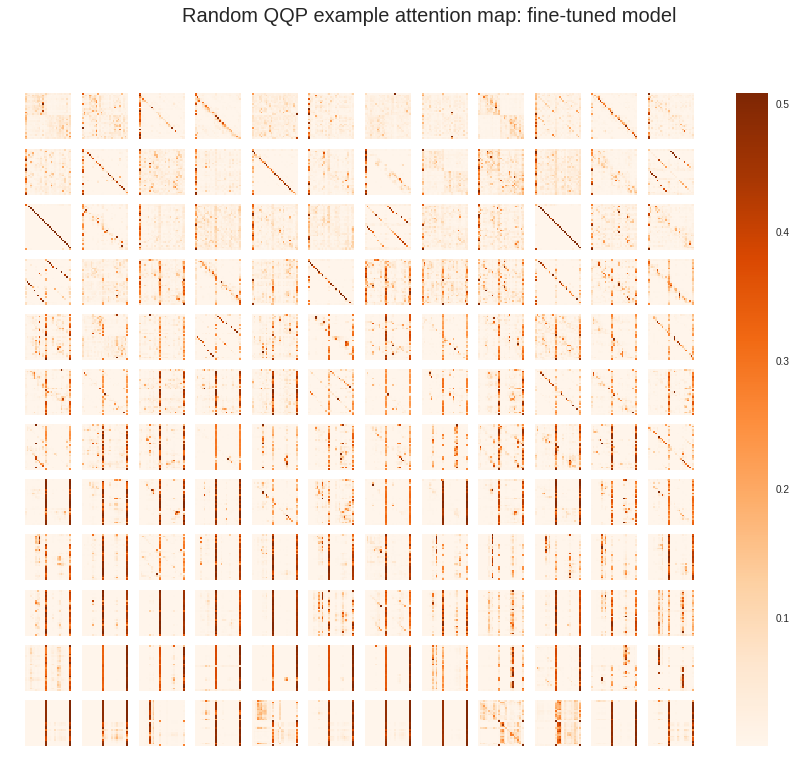

In [44]:
rand_example = random.choice(data)
input_ids, input_mask, segment_ids = convert_to_bert_inputs(rand_example[1], rand_example[2], max_len)
_, rand_output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
_, rand_output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
rand_output_finetuned = rand_output_finetuned.squeeze(0).detach().numpy()
rand_output_base = rand_output_base.squeeze(0).detach().numpy()
crop_len = torch.sum(input_mask != 0)
visualize_all(rand_output_finetuned, crop_len, title="Random {} example attention map: fine-tuned model".format(task))

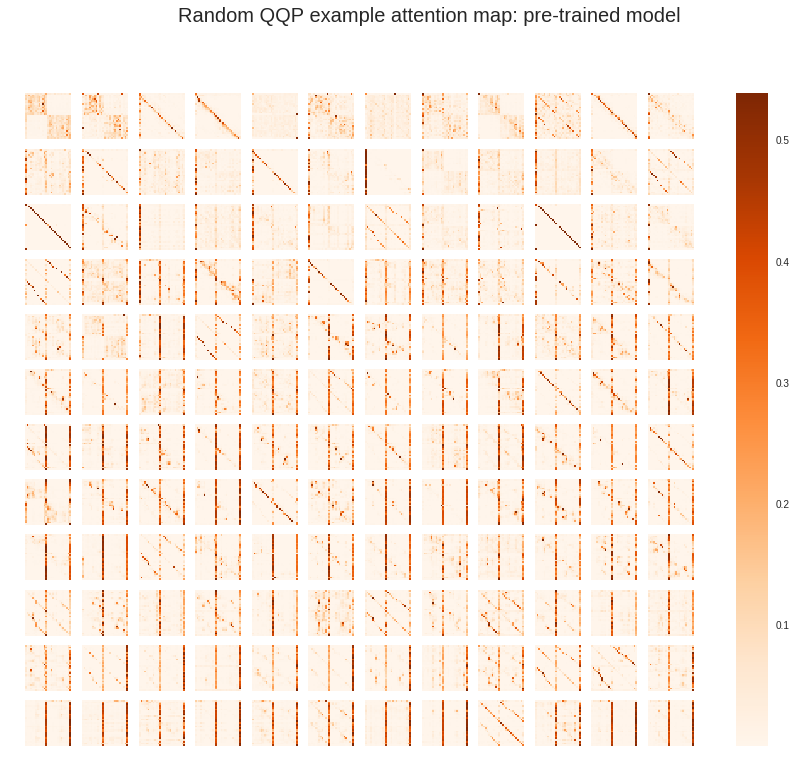

In [45]:
visualize_all(rand_output_base, crop_len, title="Random {} example attention map: pre-trained model".format(task))

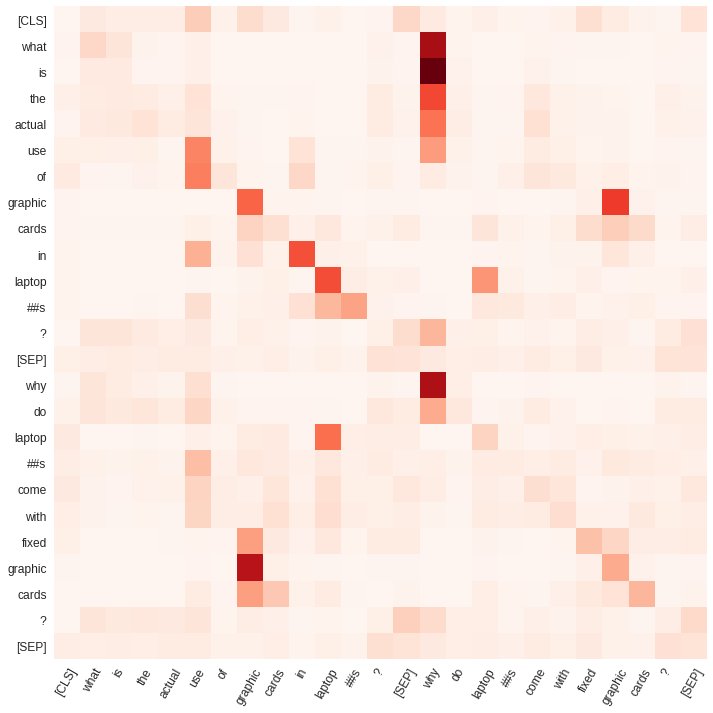

In [46]:
rand_example = random.choice(data)
input_ids, input_mask, segment_ids = convert_to_bert_inputs(rand_example[1], rand_example[2], max_len)
_, rand_output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
rand_output_finetuned = rand_output_finetuned.squeeze(0).detach().numpy()
visualize_single(rand_output_finetuned, rand_example[1], rand_example[2], max_len, 9, 8)

### 3. Cosine similarity map

100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]


Text(0, 0.5, 'Layer id')

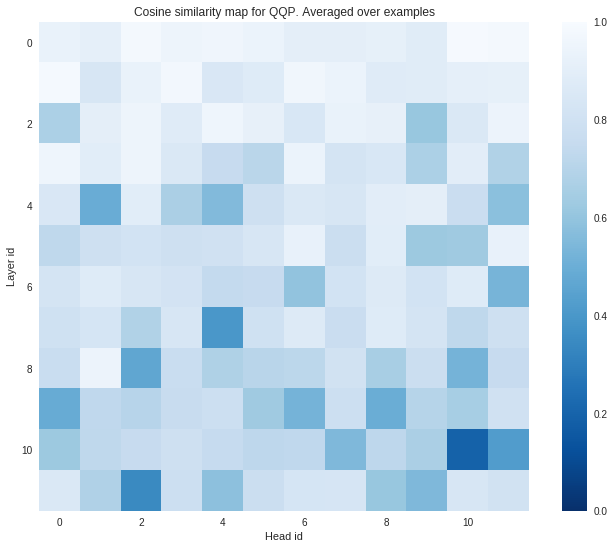

In [47]:
all_similarities = []
for example in tqdm(data):
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
    _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    _, output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    
    finetuned_vec = output_finetuned.squeeze(0).view(n_layers, n_heads, -1)
    base_vec = output_base.squeeze(0).view(n_layers, n_heads, -1)

    sim_map = torch.nn.functional.cosine_similarity(base_vec, finetuned_vec, dim=-1).detach().numpy()
    all_similarities.append(sim_map)
all_similarities = np.stack(all_similarities, axis=-1)
avg_sim = np.mean(all_similarities, axis=-1)
plt.figure(figsize=(12, 9))
plt.imshow(avg_sim, cmap='Blues_r', vmin=0, vmax=1)
plt.colorbar()
plt.grid(False)
plt.title('Cosine similarity map for {}. Averaged over examples'.format(task))
plt.xlabel('Head id')
plt.ylabel('Layer id')

### 4.1 Target nouns

100%|██████████| 1000/1000 [05:51<00:00,  2.85it/s]


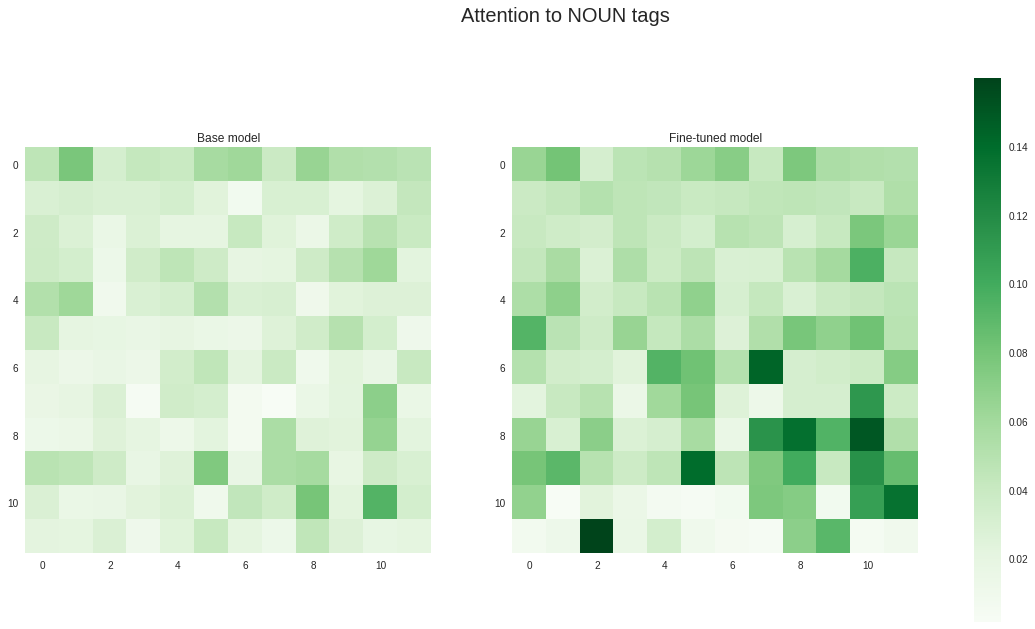

In [48]:
pos = 'NOUN'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to NOUN tags')


### 4.2 Target verbs

100%|██████████| 1000/1000 [05:51<00:00,  2.84it/s]


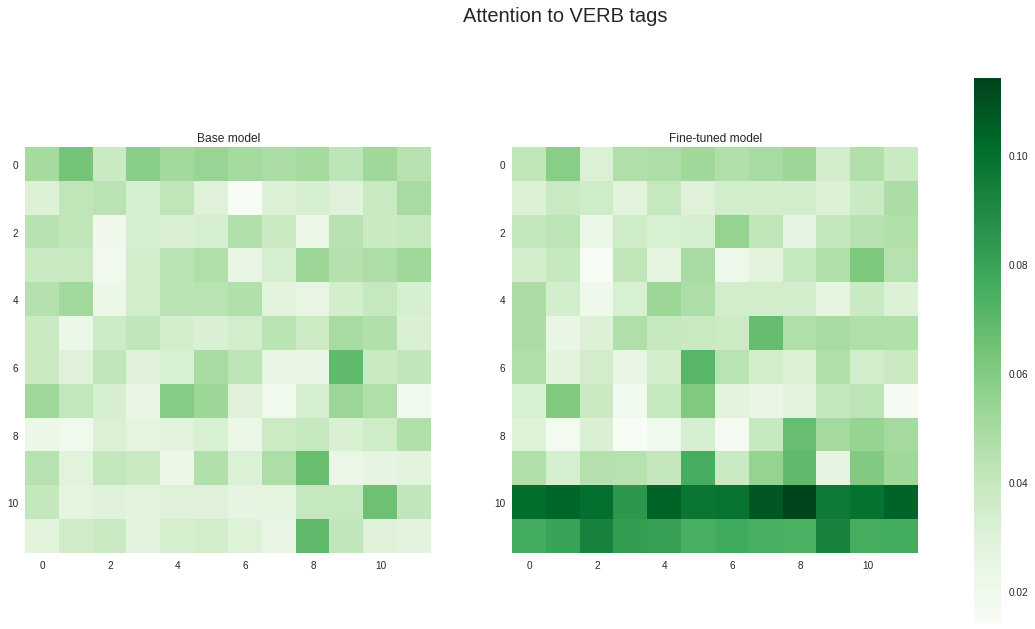

In [49]:
pos = 'VERB'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to VERB tags')


### 4.3 Target pronouns

100%|██████████| 1000/1000 [05:46<00:00,  2.88it/s]


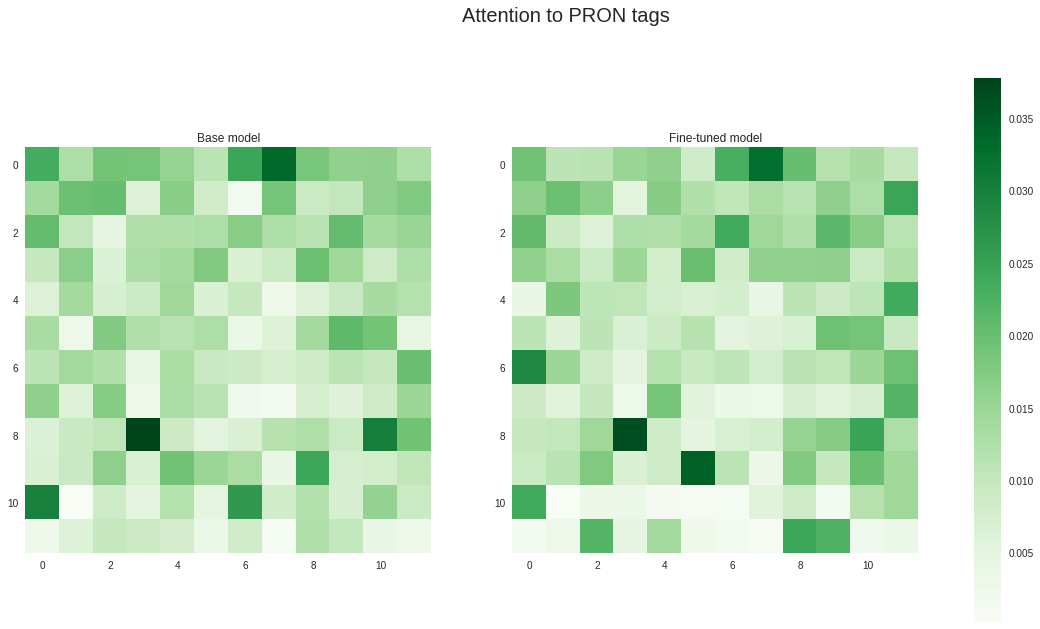

In [50]:
pos = 'PRON'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to PRON tags')


### 4.4 Target negations

100%|██████████| 1000/1000 [00:34<00:00, 28.66it/s]


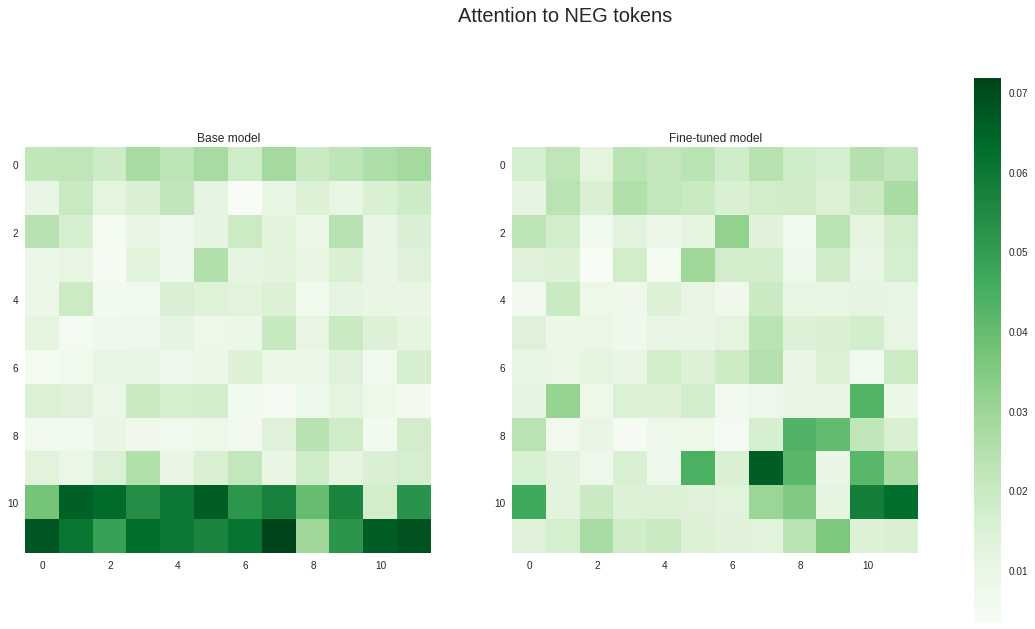

In [51]:
feature = 'NEG'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    if not detect_all_negations(example[1]) and not detect_all_negations(example[2]):
        continue
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=feature)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=feature)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to NEG tokens')


### 4.5 Target subjects

100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


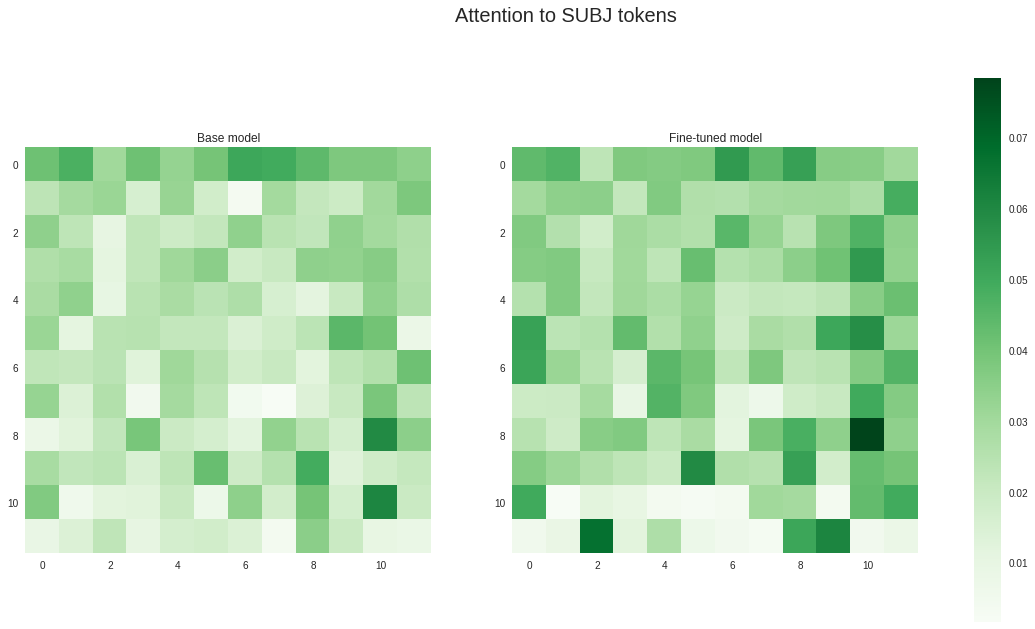

In [52]:
feature = 'SUBJ'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=feature)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=feature)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to SUBJ tokens')

### 4.6 Target objects

100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s]


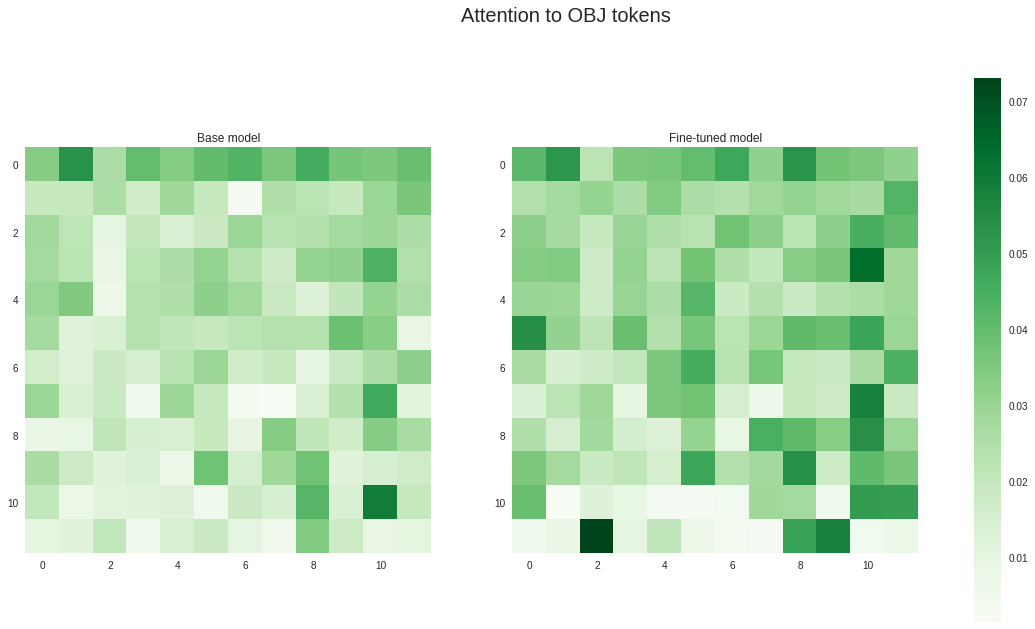

In [53]:
feature = 'OBJ'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_target_attention(example[1], example[2], max_len, model_finetuned, feature=feature)
    weights_base = analyze_target_attention(example[1], example[2], max_len, model_base, feature=feature)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to OBJ tokens')

### 4.7 Attention so SEP

100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


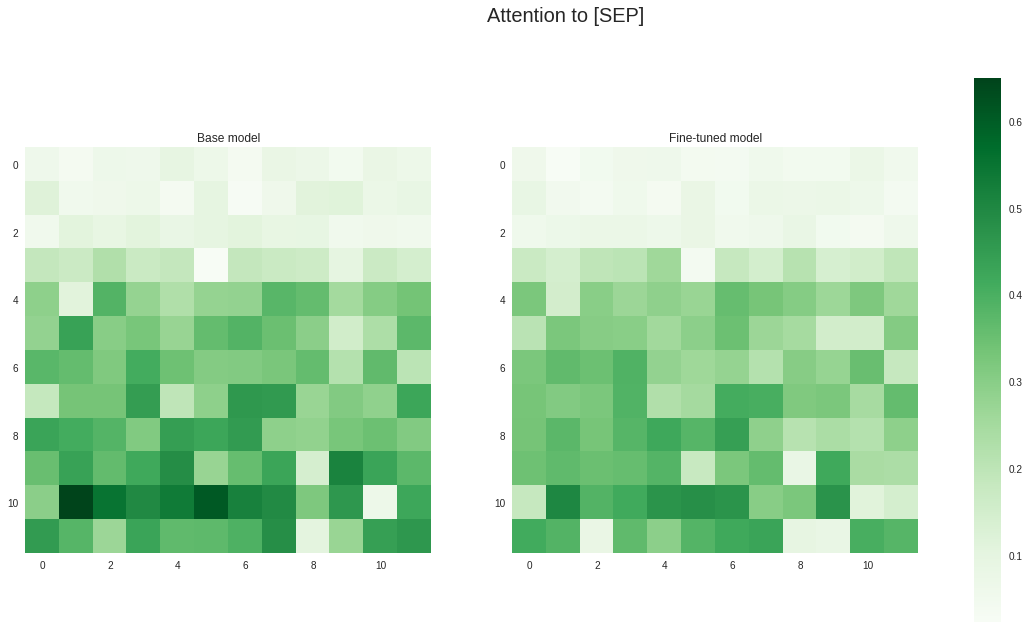

In [54]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = np.zeros((n_layers, n_heads))
    weights_base = np.zeros((n_layers, n_heads))

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
    crop_len = torch.sum(input_mask != 0)
    sep2_idx =  crop_len - 1
    sep1_idx = torch.sum(input_mask - segment_ids) - 1
    
    _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    _, output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    
    output_finetuned = output_finetuned.squeeze(0).detach().numpy()
    output_base = output_base.squeeze(0).detach().numpy()
    
    for l in range(n_layers):
        for h in range(n_heads):    
            weights_finetuned[l, h] = get_max_target_weight(output_finetuned[l, h, :crop_len, :crop_len], [sep1_idx, sep2_idx])
            weights_base[l, h] = get_max_target_weight(output_base[l, h, :crop_len, :crop_len], [sep1_idx, sep2_idx])

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to [SEP]')

### 4.8 Attention to CLS

100%|██████████| 1000/1000 [05:36<00:00,  2.97it/s]


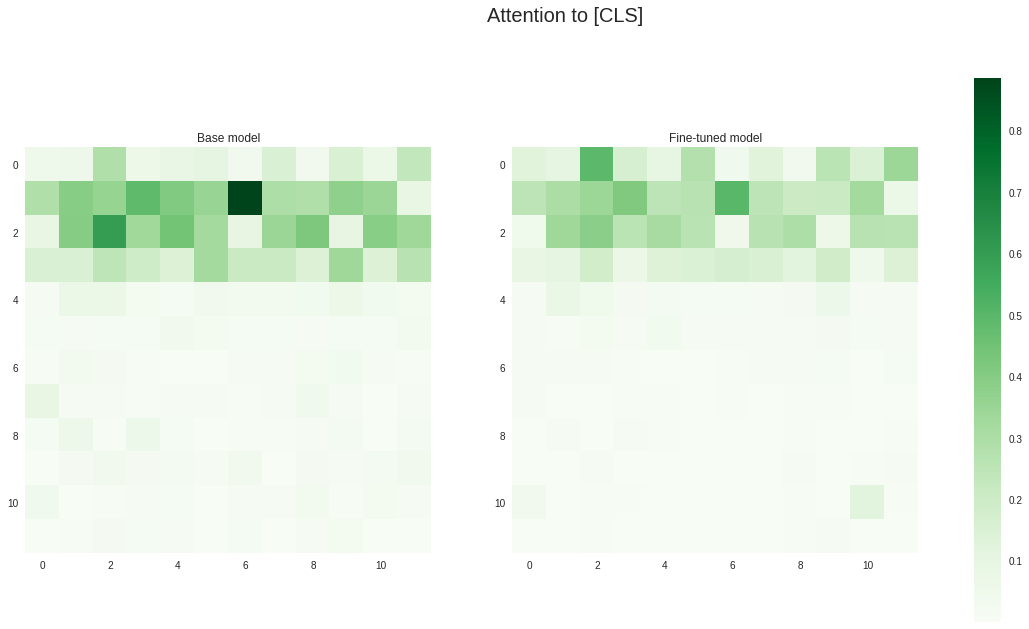

In [55]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = np.zeros((n_layers, n_heads))
    weights_base = np.zeros((n_layers, n_heads))

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
    crop_len = torch.sum(input_mask != 0)
    
    _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    _, output_base = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    
    output_finetuned = output_finetuned.squeeze(0).detach().numpy()
    output_base = output_base.squeeze(0).detach().numpy()
    
    for l in range(n_layers):
        for h in range(n_heads):    
            weights_finetuned[l, h] = np.mean(output_finetuned[l, h, :crop_len, 0])
            weights_base[l, h] = np.mean(output_base[l, h, :crop_len, 0])

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned_cls = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base_cls = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base_cls, avg_weights_finetuned_cls, 'Attention to [CLS]')

### 5.1 SUBJ-VERB relation

100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


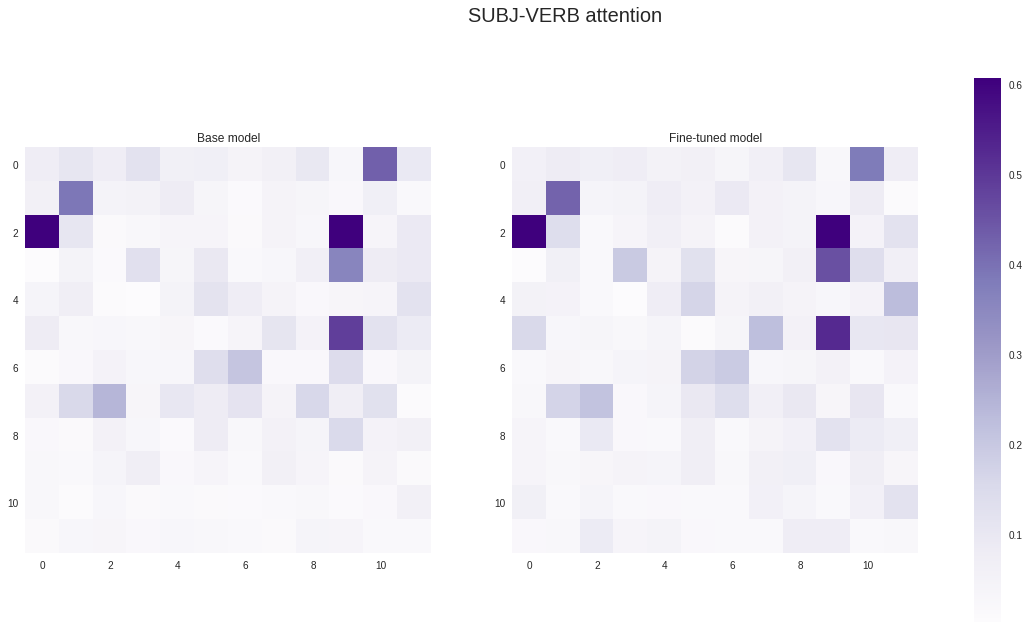

In [56]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_cross_attention(example[1], example[2], max_len, model_finetuned, relation="SUBJ-VERB")
    weights_base = analyze_cross_attention(example[1], example[2], max_len, model_base, relation="SUBJ-VERB")

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'SUBJ-VERB attention', cmap="Purples")

### 5.2 VERB-SUBJ relation

100%|██████████| 1000/1000 [06:09<00:00,  2.71it/s]


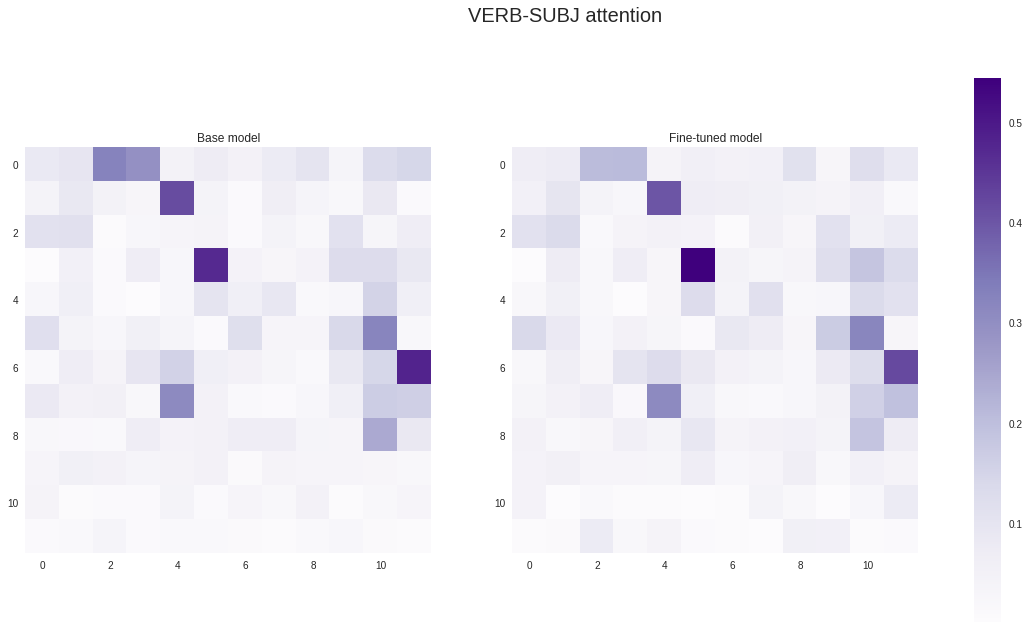

In [57]:
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(data):
    weights_finetuned = analyze_cross_attention(example[1], example[2], max_len, model_finetuned, relation="VERB-SUBJ")
    weights_base = analyze_cross_attention(example[1], example[2], max_len, model_base, relation="VERB-SUBJ")

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'VERB-SUBJ attention', cmap="Purples")

### 5.3 CLS

In [65]:
def cls_last_layer(task):
    
    if task == "MNLI":
        mnli=True
    else:
        mnli=False
        
    if task == "STS-B":
        sts = True
    else:
        sts = False
    
    data = read_dataset(task, path_to_data)
    model_finetuned = restore_model(path_to_model, sts=sts, mnli=mnli)
    if len(data) > 1000:    
        data = random.sample(data, 1000)

    all_pron_scores = []
    all_noun_scores = []
    all_verb_scores = []
    all_obj_scores = []
    all_subj_scores = []
    all_neg_scores = []
    
    all_cls_scores = []
    all_sep_scores = []
    for example in tqdm(data):
        bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(example[1], example[2], max_len)
        input_ids, input_mask, segment_ids = convert_to_bert_inputs(example[1], example[2], max_len)
        _, output_finetuned = model_finetuned(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
        output_finetuned = output_finetuned.squeeze(0).detach().numpy()
        
        crop_len = torch.sum(input_mask != 0)
        sep2_idx =  crop_len - 1
        sep1_idx = torch.sum(input_mask - segment_ids) - 1

        last_layer = output_finetuned[11]

        prons = detect_all_pos(example[1], 'PRON').union(detect_all_pos(example[2], 'PRON'))
        nouns = detect_all_pos(example[1], 'NOUN').union(detect_all_pos(example[2], 'NOUN'))
        verbs = detect_all_pos(example[1], 'VERB').union(detect_all_pos(example[2], 'VERB'))
        objs = detect_all_dep(example[1], 'OBJ').union(detect_all_dep(example[2], 'OBJ'))
        subjs = detect_all_dep(example[1], 'SUBJ').union(detect_all_dep(example[2], 'SUBJ'))
        negs = detect_all_negations(example[1]).union(detect_all_negations(example[2]))

        prons_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(pron) for pron in prons]))
        nouns_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(noun) for noun in nouns]))
        verbs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(verb) for verb in verbs]))
        objs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(obj) for obj in objs]))
        subjs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(subj) for subj in subjs]))
        negs_tokens = list(itertools.chain.from_iterable([tokenizer.tokenize(neg) for neg in negs]))

        target_prons_ids = [i for i, token in enumerate(bert_tokens) if token in prons_tokens]
        target_nouns_ids = [i for i, token in enumerate(bert_tokens) if token in nouns_tokens]
        target_verbs_ids = [i for i, token in enumerate(bert_tokens) if token in verbs_tokens]
        target_objs_ids = [i for i, token in enumerate(bert_tokens) if token in objs_tokens]
        target_subjs_ids = [i for i, token in enumerate(bert_tokens) if token in subjs_tokens]
        target_negs_ids = [i for i, token in enumerate(bert_tokens) if token in negs_tokens]

        pron_scores = []
        noun_scores = []
        verb_scores = []
        subj_scores = []
        obj_scores = []
        neg_scores = []
        
        cls_scores = []
        sep_scores = []

        for h in range(n_heads):
            if target_prons_ids:              
                pron_score = max(last_layer[h, 0, target_prons_ids])
                pron_scores.append(pron_score)

            if target_nouns_ids:              
                noun_score = max(last_layer[h, 0, target_nouns_ids])
                noun_scores.append(noun_score)

            if target_verbs_ids:              
                verb_score = max(last_layer[h, 0, target_verbs_ids])        
                verb_scores.append(verb_score)

            if target_objs_ids:              
                obj_score = max(last_layer[h, 0, target_objs_ids])        
                obj_scores.append(obj_score)

            if target_subjs_ids:              
                subj_score = max(last_layer[h, 0, target_subjs_ids])        
                subj_scores.append(subj_score)

            if target_negs_ids:
                neg_score = max(last_layer[h, 0, target_negs_ids])        
                neg_scores.append(neg_score)            
            
            cls_scores.append(last_layer[h, 0, 0])
            sep_scores.append(max([last_layer[h, 0, sep1_idx], last_layer[h, 0, sep2_idx]]))

        pron_scores = np.array(pron_scores)
        noun_scores = np.array(noun_scores)
        verb_scores = np.array(verb_scores)
        obj_scores = np.array(obj_scores)
        subj_scores = np.array(subj_scores)
        neg_scores = np.array(neg_scores)
        
        cls_scores = np.array(cls_scores)
        sep_scores = np.array(sep_scores)

        if target_prons_ids:
            all_pron_scores.append(pron_scores)
        if target_nouns_ids:
            all_noun_scores.append(noun_scores)
        if target_verbs_ids: 
            all_verb_scores.append(verb_scores)
        if target_objs_ids: 
            all_obj_scores.append(obj_scores)
        if target_subjs_ids: 
            all_subj_scores.append(subj_scores)
        if target_negs_ids: 
            all_neg_scores.append(neg_scores)
            
        all_cls_scores.append(cls_scores)
        all_sep_scores.append(sep_scores)

    all_pron_scores = np.mean(np.stack(all_pron_scores), axis=0)
    all_noun_scores = np.mean(np.stack(all_noun_scores), axis=0)
    all_verb_scores = np.mean(np.stack(all_verb_scores), axis=0)
    all_obj_scores = np.mean(np.stack(all_obj_scores), axis=0)
    all_subj_scores = np.mean(np.stack(all_subj_scores), axis=0)
    all_neg_scores = np.mean(np.stack(all_neg_scores), axis=0)
    
    all_cls_scores = np.mean(np.stack(all_cls_scores), axis=0)
    all_sep_scores = np.mean(np.stack(all_sep_scores), axis=0)
    
    return (all_pron_scores, all_noun_scores, all_verb_scores, all_obj_scores, 
            all_subj_scores, all_neg_scores, all_cls_scores, all_sep_scores)



In [66]:
def visualize_cls(data, task):
    all_pron_scores, all_noun_scores, all_verb_scores, all_obj_scores, all_subj_scores, all_neg_scores, all_cls_scores, all_sep_scores = data
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True, 
                                                                         figsize=(12, 6))
    plt.subplots_adjust(wspace=0.04, hspace=0)

    ax1.imshow(np.expand_dims(all_pron_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax2.imshow(np.expand_dims(all_noun_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax3.imshow(np.expand_dims(all_verb_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax4.imshow(np.expand_dims(all_obj_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax5.imshow(np.expand_dims(all_subj_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax6.imshow(np.expand_dims(all_neg_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    ax7.imshow(np.expand_dims(all_cls_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")
    im = ax8.imshow(np.expand_dims(all_sep_scores, 0), vmin=0, vmax=0.5, cmap="YlGn")

    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax4.grid(False)
    ax5.grid(False)
    ax6.grid(False)
    ax7.grid(False)
    ax8.grid(False)

    ax1.set_title("PRON", fontsize=28)
    ax2.set_title("NOUN", fontsize=28)
    ax3.set_title("VERB", fontsize=28)
    ax4.set_title("OBJ", fontsize=28)
    ax5.set_title("SUBJ", fontsize=28)
    ax6.set_title("NEG", fontsize=28)
    ax7.set_title("[CLS]", fontsize=28)
    ax8.set_title("[SEP]", fontsize=28)
    
    ax1.set_yticks([0])
    ax7.set_xticks(range(12))
#     ax8.set_xticks(range(12))

    ax1.set_yticklabels([], fontsize=12)
    ax3.set_yticklabels([], fontsize=12)
    ax5.set_yticklabels([], fontsize=12)
    ax7.set_yticklabels([], fontsize=12)

    ax7.set_xticklabels(range(1, 13), fontsize=14)
    ax8.set_xticklabels(range(1, 13), fontsize=14)

#     fig.colorbar(im, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], pad=0.05)


    fig.suptitle(task, fontsize=32, weight='bold')

100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]


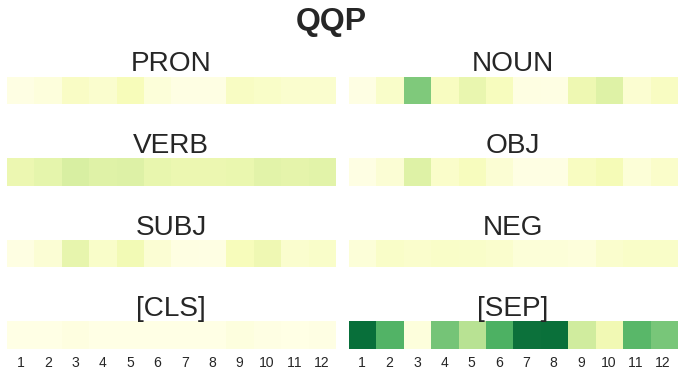

In [67]:
data_qqp = cls_last_layer("QQP")
visualize_cls(data_qqp, "QQP")

## 7. BaseBERT study

In [72]:
def exceeds_token_limit(span, n_max=3):
    tokens = word_tokenize(span)
    return len(tokens) > n_max

In [73]:
def is_close(sentence, target, relations):
    tokens = word_tokenize(sentence)
    
    target_token = sentence[target[0]:target[1]]
    try:
        target_token_idx = tokens.index(target_token)
    except Exception:
        return True
        
    relation_spans = [sentence[relation[0]:relation[1]] for relation in relations]
    relation_tokens = list(itertools.chain.from_iterable([word_tokenize(span) for span in relation_spans]))

    # make sure we don't go beyond list bounds
    padded_tokens = ['<PAD>', '<PAD>'] + tokens + ['<PAD>', '<PAD>']
    for token in padded_tokens[target_token_idx: target_token_idx + 5]:
        if token in relation_tokens:
            return True    
    return False

In [74]:
annotations = []
for lu in tqdm(fn.lus()):
    core_list = list(itertools.chain.from_iterable([[fe['name'] for fe in item] for item in lu['frame']['FEcoreSets']]))
    corpora = lu['subCorpus']
    for corpus in corpora:
        sentences = corpus['sentence']
        for sentence in sentences:
            text = sentence['text']
            
            tokens = word_tokenize(text)
            if len(tokens) > 12:
                continue
            
            try:
                target = sentence['Target']
            except Exception:
                continue
            
            # if target word appears many times
            if len(target) > 1:
                continue
                
            # filter cases with more than 3 tokens
            fes = sentence['FE'][0]
            flag = True
            for span in fes:
                if exceeds_token_limit(text[span[0]:span[1]]):
                    flag = False
            if not flag:
                continue
                
            # filter relations too close to the target
            target_ind = target[0]
            if is_close(text, target_ind, fes):
                continue
            
            core_fes = [(fe[0], fe[1]) for fe in fes if fe[2] in core_list]
            
            # filter no core fes
            if not core_fes:
                continue
            annotations.append({"sentence": text,
                               "target": target[0],
                               "links": core_fes})

100%|██████████| 13572/13572 [05:06<00:00, 44.35it/s]


In [56]:
annotations_reformatted = []
for annotation in annotations:
    sentence = annotation['sentence']
    target = sentence[annotation['target'][0]:annotation['target'][1]]
    links = []
    for link in annotation['links']:
        links.append(sentence[link[0]:link[1]])
    annotations_reformatted.append({'sentence': sentence, 'target': target, 'links':links})

In [57]:
for example in annotations_reformatted:
    print(example['sentence'], example["target"], example['links'], '\n')

Mitch 's chin dipped an inch and then lifted again .  lifted ["Mitch 's chin"] 

His head sags , nods once , jerks up again .  nods ['His head'] 

He guessed that a reaction was expected and shrugged .  shrugged ['He'] 

He sat up and stretched , then stripped off his gloves .  stretched ['He'] 

Caterina shut her eyes and twitched .  twitched ['Caterina'] 

This is a small island and tongues are beginning to wag .  wag ['tongues'] 

Peach tried and tried , but the toes would n't wiggle .  wiggle ['the toes'] 

He caught Carol 's eye , and winked .  winked ['He'] 

He tried to wink but , naturally , failed .  wink ['He'] 

There are some rolls a film star just has to grab … grab ['a film star'] 

'' I do n't know . know ['I'] 

( Do n't say Stephanopoulos did n't know . know ['Stephanopoulos'] 

I 'm not given to making guesses . "  guesses ['I'] 

He made a guess .  guess ['He'] 

For the present we need to proceed by inferences .  inferences ['we'] 

I ca n't learn again now .  learn

In [58]:
# saving annotations (indices)
with open('framenet_examples_indices.txt', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    for example in annotations:
        links = example['links']
        sentence = example['sentence']
        target = example['target']
        writer.writerow((sentence, target, links))

In [59]:
# saving annotations
with open('framenet_examples_words.txt', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    for example in annotations_reformatted:
        links = example['links']
        sentence = example['sentence']
        target = example['target']
        writer.writerow((sentence, target, links))

In [61]:
def analyze_sem_links(model, example):
    """
    Analyze weights of semantic links
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(example['sentence'], "", max_len=20)
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(example['sentence'], "", max_len=20)
    crop_len = torch.sum(input_mask != 0)
    
    _, output = model(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
    output = output.squeeze(0).detach().numpy()
    
    target_start, target_end = example['target'][0], example['target'][1]
    target_tokens = tokenizer.tokenize(example['sentence'][target_start:target_end])
    target_idx = [bert_tokens.index(token) for token in target_tokens]
    
    all_source_idx = []
    for link in example['links']:
        source_start, source_end = link[0], link[1]
        source_tokens = tokenizer.tokenize(example['sentence'][source_start:source_end])
        source_idx = [bert_tokens.index(token) for token in source_tokens]
        all_source_idx.append(source_idx)
    all_source_idx = list(itertools.chain.from_iterable(all_source_idx))
    
    weights = np.zeros((n_layers, n_heads))
    for l in range(n_layers):
        for h in range(n_heads):    
            weights[l, h] = get_max_source_target_weight(output[l, h, :crop_len, :crop_len], all_source_idx, target_idx)

    return weights
    

In [62]:
all_weights = []
for example in tqdm(annotations):
    weights = analyze_sem_links(model_base, example)
    all_weights.append(weights)
    
all_weights = np.mean(np.stack(all_weights), axis=0)


100%|██████████| 473/473 [00:19<00:00, 24.06it/s]


([<matplotlib.axis.YTick at 0x7f9ff47306a0>,
 <a list of 12 Text yticklabel objects>)

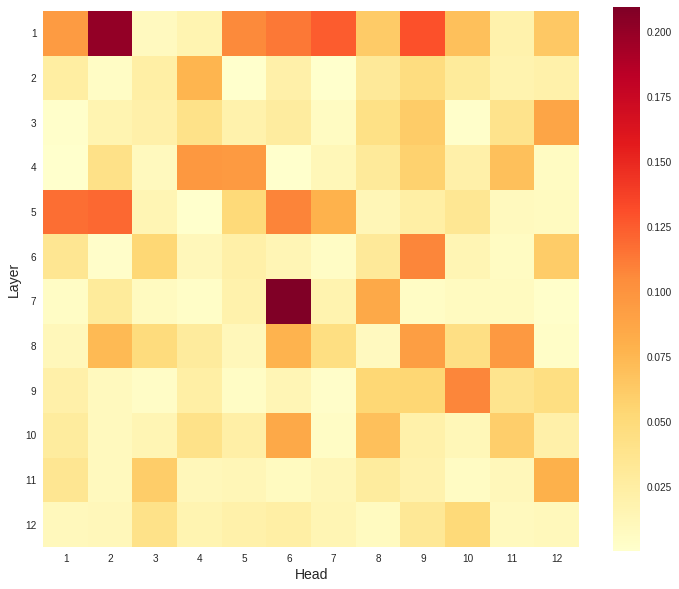

In [63]:
plt.figure(figsize=(12, 10))
plt.imshow(all_weights, cmap='YlOrRd')
plt.colorbar()
plt.grid(False)
plt.xlabel("Head", fontsize=14)
plt.ylabel("Layer", fontsize=14)
plt.xticks(ticks=range(12), labels=range(1, 13))
plt.yticks(ticks=range(12), labels=range(1, 13))

He was becoming agitated . 
Target: agitated
He


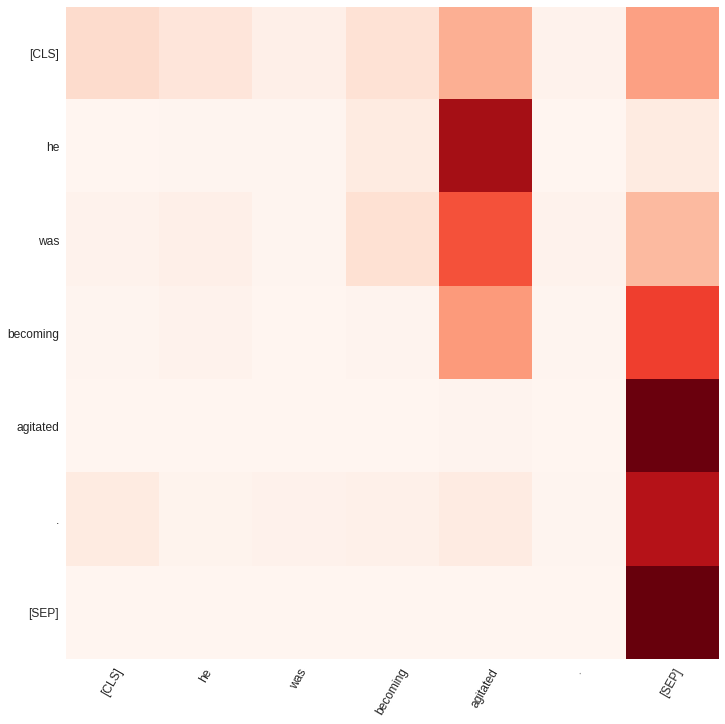

In [332]:
random_annotation = random.choice(annotations)
sentence = random_annotation['sentence']
target = sentence[random_annotation['target'][0]:random_annotation['target'][1]]
print(sentence)
print("Target:", target)
for link in random_annotation['links']:
    print(sentence[link[0]:link[1]])
bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(random_annotation['sentence'], "", max_len=20)
input_ids, input_mask, segment_ids = convert_to_bert_inputs(random_annotation['sentence'], "", max_len=20)
crop_len = torch.sum(input_mask != 0)
    
_, output = model_base(input_ids.unsqueeze(0),  segment_ids.unsqueeze(0), input_mask.unsqueeze(0))
output = output.squeeze(0).detach().numpy()
visualize_single(output, random_annotation['sentence'], "", max_len, 6, 5)

In [344]:
bert_tokens[:crop_len]

['[CLS]', 'he', 'was', 'becoming', 'agitated', '.', '[SEP]']

([<matplotlib.axis.YTick at 0x7ff84a5cdda0>,
 <a list of 7 Text yticklabel objects>)

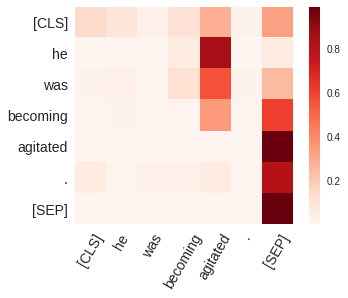

In [348]:
plt.imshow(output[6, 5, :crop_len, :crop_len], cmap='Reds')
plt.grid(False)
plt.colorbar()
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rotation=60, fontsize=14)
plt.yticks(ticks=range(crop_len), labels=bert_tokens[:crop_len],  fontsize=14)

([<matplotlib.axis.YTick at 0x7ff84a514908>,
 <a list of 7 Text yticklabel objects>)

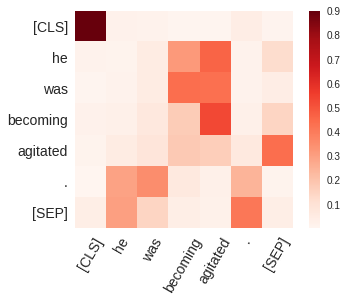

In [349]:
plt.imshow(output[0, 1, :crop_len, :crop_len], cmap='Reds')
plt.grid(False)
plt.colorbar()
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rddotation=60, fontsize=14)
plt.yticks(ticks=range(crop_len), labels=bert_tokens[:crop_len],  fontsize=14)

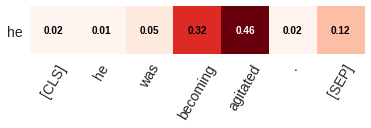

In [370]:
to_show = np.expand_dims(output[0, 1, 1, :crop_len], 0)
plt.imshow(to_show, cmap='Reds')
plt.grid(False)
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rotation=60, fontsize=14)
plt.yticks(ticks=range(1), labels=['he'], fontsize=14)
colors = ['black', 'black', 'black', 'black', 'white', 'black', 'black']
for i, value in enumerate(to_show[0]):
    plt.text(i, 0, "{:.2f}".format(value), ha="center", va="center", weight='bold', color=colors[i])

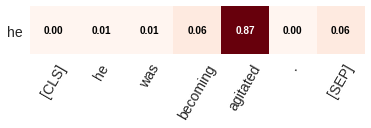

In [371]:
to_show = np.expand_dims(output[6, 5, 1, :crop_len], 0)
plt.imshow(to_show, cmap='Reds')
plt.grid(False)
plt.xticks(ticks=range(crop_len), labels=bert_tokens[:crop_len], rotation=60, fontsize=14)
plt.yticks(ticks=range(1), labels=['he'], fontsize=14)
colors = ['black', 'black', 'black', 'black', 'white', 'black', 'black']
for i, value in enumerate(to_show[0]):
    plt.text(i, 0, "{:.2f}".format(value), ha="center", va="center", weight='bold', color=colors[i])